In [1]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import math

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
yf.pdr_override()

In [2]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [3]:
tickers = ['AAPL', 'MSFT', 'INTC', 'AMD', 'SMH', 'TSLA', 'NVDA', 'JPM']


df = pdr.get_data_yahoo(tickers, interval='5m', period='15d')['Adj Close']
# df = pdr.get_data_yahoo(tickers, interval='5m', start="2022-10-1", end="2022-10-25")['Adj Close']

df.describe()

[*********************100%***********************]  8 of 8 completed


,AAPL,AMD,INTC,JPM,MSFT,NVDA,SMH,TSLA
count,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000,1171.000000
mean,144.670802,58.575797,26.425850,116.054930,234.865753,122.693292,182.105386,218.163479
std,4.885773,1.599319,0.960201,7.516640,6.697812,7.158187,5.552196,6.763043
min,135.279999,54.959999,24.705000,101.629997,220.699997,109.269997,167.580002,199.190704
25%,140.595001,57.410000,25.820000,109.310001,229.399994,116.989998,177.268547,212.927505
50%,143.830002,58.095001,26.320000,117.400002,235.324997,120.507500,181.054993,220.050003
75%,148.010048,59.632500,27.152551,122.860001,238.163605,129.406799,187.114998,223.208206
max,157.320007,62.500000,29.135000,126.202003,250.759995,138.339996,192.789993,231.449997


[('AAPL', 'NVDA'), ('AMD', 'INTC'), ('AMD', 'JPM'), ('AMD', 'NVDA'), ('AMD', 'SMH')]


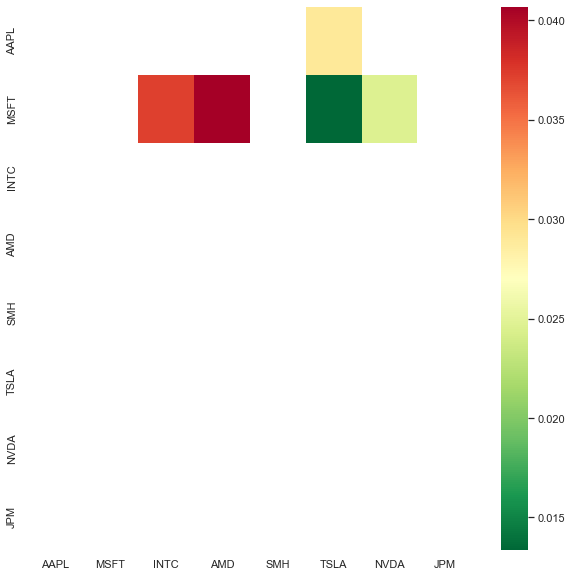

In [4]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
scores, pvalues, pairs = find_cointegrated_pairs(df)
import seaborn
fig, ax = plt.subplots(figsize=(10,10))
seaborn.heatmap(pvalues, xticklabels=tickers, yticklabels=tickers, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.05)
                )
print(pairs)

In [5]:
S1 = df['AAPL']
S2 = df['NVDA']

score, pvalue, _ = coint(S1, S2)
pvalue

0.0290418834958021

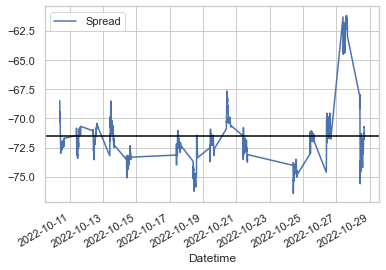

In [6]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['AAPL']
b = results.params['AAPL']

spread = S2 - b * S1
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);


df1 = spread
df1 = df1.T

df1.index = df1.index.tz_localize(None)
df1.to_excel(r'AAPLNVDA5Min.xlsx')

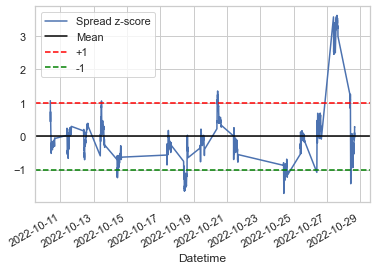

In [7]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

normalized = zscore(spread)

zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

df = zscore(spread)

df=df.T
df.index = df.index.tz_localize(None)

df.to_excel(r'AAPLNVDA5MinNormalized.xlsx')